# STL10 PCA and GMM Experiment
#### by Pio Lauren T. Mendoza

In this notebook the Principal Component Analysis (PCA) and Gaussian Mixture Models will be built from scratch by only using pure python and numpy. Their performance will be evaluated under various conditions.

## Importing Modules

In [71]:
from numpy.random import default_rng
from PIL import Image
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np

rng = default_rng()

%matplotlib inline

## Principal Component Analysis

High dimensional data are is ubiquitous these days. Even a handheld smart phone can capture high resolution RGB images. These high resolution RGB images have tons of information. Each pixel represent an information which comprises a high dimensional data. These high dimensional data are sometimes diffucult to store due to its size. It may also be difficult to analyze and visualize since high dimensional data is composed of large amount of information. Luckily, these high dimensional data are usually over defined. They are composed of redundant information which has correlation which can be utilized for dimensionality reduction. Principal component analysis is an algorithm for linear data dimensionality reduction [\[1\]](#1). PCA tries to find the minimum set of basis that can represent the data in a compact manner. These basis vectors were called as *"best fitting lines"* in the original paper of Pearson in 1901 [\[2\]](#2). 

## Data Preparation

The `torchvision` library will be used for dataloading. For more information about the STL10 dataset api of `torchvision` you may visit the [documentation](https://pytorch.org/vision/stable/_modules/torchvision/datasets/stl10.html). STL10 unlabeled split dataset has 100k images but for this experiment only 10k images will be used. This 10k images will be sampled in the STL10 unlabeled split. Due to computational power limit instead of using the RGB images, it will be first converted into grayscale images.

In [2]:
ds_unlabeled = datasets.STL10(root="./data", split="unlabeled", download=True)
classes = ds_unlabeled.classes
print(f"STL10 unlabeled split size: {len(ds_unlabeled)}")

Files already downloaded and verified
STL10 unlabeled split size: 100000


In [20]:
DATASET_SIZE = 10_000
IMAGE_RESOLUTION = ds_unlabeled.data.shape[2:]

data_RGB = rng.choice(ds_unlabeled.data, size=DATASET_SIZE , replace=False)

[[[ 18  18  18 ... 202 182 196]
  [ 18  18  18 ... 178 167 169]
  [ 18  17  17 ... 151 162 152]
  ...
  [ 32  34  37 ... 110 136 132]
  [ 31  34  37 ... 113 114 130]
  [ 30  35  32 ... 140 136 139]]

 [[ 15  15  15 ... 188 168 182]
  [ 15  15  15 ... 164 153 155]
  [ 17  16  16 ... 137 148 138]
  ...
  [ 37  39  42 ...  94 122 120]
  [ 37  39  42 ...  96  97 113]
  [ 37  40  37 ... 120 117 120]]

 [[ 22  22  22 ... 158 139 153]
  [ 22  22  22 ... 136 125 127]
  [ 23  22  22 ... 111 122 112]
  ...
  [ 67  69  72 ...  65  82  72]
  [ 63  68  73 ...  64  58  68]
  [ 59  68  69 ...  87  79  78]]]


In [32]:
data = np.empty((DATASET_SIZE, *IMAGE_RESOLUTION))

for idx, image in enumerate(data_RGB):
    data[idx] = np.asarray(Image.fromarray(image.transpose((1,2,0))).convert('L'))/255

## Plotting Function

In [65]:
def plot_sample(data, indices, title):
    figure = plt.figure(figsize=(15,15))
    plt.suptitle(title, fontsize=35)
    num_images = len(indices)
    for count, idx in enumerate(indices, 1):
        figure.add_subplot(3,int(np.ceil(num_images/3)), count)
        plt.imshow(data[idx], cmap="gray")
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()

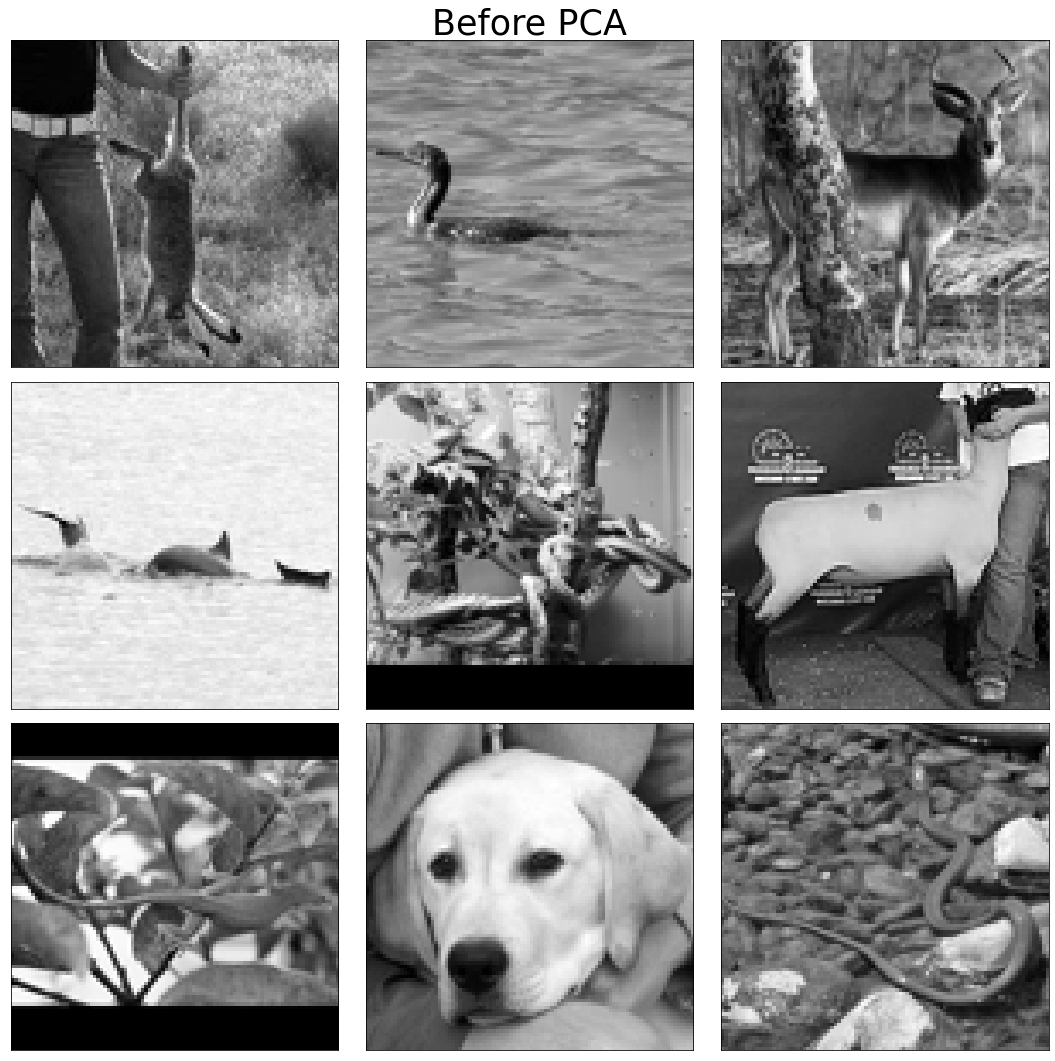

In [72]:
plot_sample(data, list(range(9)), 'Before PCA')

## References

<a id='1'>[\[1\] M. P. Deisenroth, A. A. Faisal, and C. S. Ong, Mathematics for Machine Learning. Cambridge, United Kingdom: Cambridge University Press, 2020.](https://mml-book.com)</a>  
<a id='2'>[\[2\] Pearson, K. 1901. On lines and planes of closest fit to systems of points in space. Philosophical Magazine 2:559-572](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1056/2012/10/pearson1901.pdf)</a>  
<a id='3'>[\[3\] A. Coates, A. Ng, en H. Lee, “An Analysis of Single Layer Networks in Unsupervised Feature Learning”, in AISTATS, 2011.](https://cs.stanford.edu/~acoates/stl10/)</a>  
